Binary classification between subjects with ICD10 cat 10 and those whithout!

### \\\ Currently used ///

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split

# sklearn functions
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters

In [5]:
torch.__version__

'1.0.0'

In [6]:
# use multiple GPUs
gpu = 4
multi_gpus = None#[0, 1, 2]
b = 4
zero_one_normalize = False
dtype = np.float64

In [7]:
# load mask
mask = None

In [8]:
table = "/analysis/ritter/projects/UKbiobank/Eitel_ICD/tables/participants_transMRI_T1-ICD10_G_binary-under.csv"

In [9]:
# load dataset and show first 5 rows
df = pd.read_csv(table)
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
0,0,1100042,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100042,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,0YY,1NN,1NN,1NN,9Na,9Na
1,1,1100675,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100675,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,9else,1NN,0YY,9else,1NN,9else,9Na,9Na
2,2,1180478,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1180478,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,2YN,0YY,1NN,0YY,9Na,9Na
3,3,1112124,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1112124,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,9else,0YY,0YY,0YY,9else,1NN,1NN,9Na,9Na
4,4,1148079,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1148079,20252_2_0,20253_2_0,20249_2_0,Female,[],...,3SitY,3NY,0YY,3NY,0YY,3NY,1NN,1NN,9Na,9Na


In [10]:
# shuffle the dataset
df = df.sample(frac=1) # NOTE: use all!
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
281,281,1162764,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1162764,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,9else,0YY,3NY,1NN,1NN,9Na,9Na
39,39,1095425,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1095425,20252_2_0,20253_2_0,20249_2_0,Female,[],...,7PntA,2YN,2YN,1NN,0YY,1NN,1NN,1NN,MH.VH,MH.VH
953,953,1176520,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1176520,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,1NN,1NN,1NN,1NN,1NN,1NN,VH.VH,VH.EH
870,870,1149642,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1149642,20252_2_0,20253_2_0,20249_2_0,Male,[],...,3SitY,0YY,0YY,2YN,0YY,1NN,1NN,0YY,VH.VH,VH.VH
10,10,1022356,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1022356,20252_2_0,20253_2_0,NaN,Male,[],...,5DocR,0YY,0YY,1NN,1NN,1NN,1NN,1NN,9Na,9Na


In [11]:
df.groupby(["Sex"])["PTID"].count()

Sex
Female    1005
Male       849
Name: PTID, dtype: int64

In [12]:
class UKBGDataset(Dataset):
    def __init__(self, dataframe, transform=None, mask=None, z_factor=None):
        self.df = dataframe
        self.transform = transform
        self.mask = mask
        self.z_factor = z_factor
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if isinstance(idx, torch.FloatTensor):
            idx = idx.item()
        idx = int(idx)
        
        path = self.df.iloc[idx]['file_path']
        image = load_nifti(path, mask=self.mask, z_factor=self.z_factor)
        #label = self.df.iloc[idx]['ICD10_G_bool']
        #label = torch.FloatTensor([int(label)])
        
        label = self.df.iloc[idx]['Sex']
        label = torch.FloatTensor([int(label == "Male")])
        
        if self.transform:
            image = self.transform(image)
        
        sample = {
            "image" : image,
            "label" : label
         }
        return sample

In [13]:
augmentations = [SagittalFlip(), SagittalTranslate(dist=(-2, 3))]

In [14]:
intensity = IntensityRescale(masked=False)
input_trans = transforms.Compose(augmentations + [intensity, ToTensor()])
#input_trans = transforms.Compose([ToTensor()])

In [15]:
ukb_data = UKBGDataset(df, transform=input_trans, mask=mask)#, z_factor=0.5)

In [16]:
len(ukb_data)

1854

In [17]:
# split train/test
train_df = df.sample(frac=0.8, random_state=32)
test_df = df[~df["PTID"].isin(train_df["PTID"])]

In [18]:
sample = ukb_data[3]
img = sample["image"]

In [19]:
img.shape

torch.Size([1, 182, 218, 182])

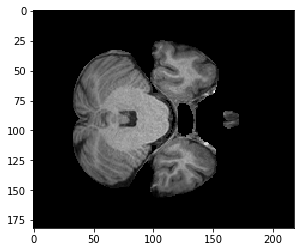

In [20]:
plt.imshow(img[0][:,:,40], cmap='gray')

In [21]:
sample["label"]

tensor([1.])

# Define the classifier

In [22]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.dropout = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 16, kernel_size=3, stride=1, padding=0)
        self.bn_1 = nn.BatchNorm3d(16)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_2 = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=0)
        self.bn_2 = nn.BatchNorm3d(32)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_3 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=0)
        self.bn_3 = nn.BatchNorm3d(64)
        self.Conv_4 = nn.Conv3d(64, 32, kernel_size=3, stride=1, padding=0)
        self.bn_4 = nn.BatchNorm3d(32)
        self.Conv_5 = nn.Conv3d(32, 16, kernel_size=3, stride=1, padding=0)
        self.bn_5 = nn.BatchNorm3d(16)
        self.pool_4 = nn.MaxPool3d(kernel_size=4, stride=3, padding=0)
        
        # 4, 64, 1, 2, 1
        self.classifier_scratch = nn.Sequential(
            #nn.Dropout(0.6),
            nn.Linear(7056, 512),
            #nn.Dropout(0.6),
            nn.Linear(512, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.relu(self.bn_1(self.Conv_1(x)))
        h = self.dropout(self.pool_1(x))
        x = F.relu(self.bn_2(self.Conv_2(h)))
        if print_size:
            print(x.shape)
        h = self.dropout(self.pool_2(x))
        x = F.relu(self.bn_3(self.Conv_3(h)))
        if print_size:
            print(x.shape)
        x = F.relu(self.bn_4(self.Conv_4(x)))
        if print_size:
            print(x.shape)
        x = F.relu(self.bn_5(self.Conv_5(x)))
        if print_size:
            print(x.shape)
        h = self.dropout(self.pool_4(x))
        if print_size:
            print(h.shape)
        
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [23]:
if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)

In [24]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 3752849


# Training

In [25]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    #for train_idx, val_idx in kf.split(data):#, df["label"]):
    for trial in range(10):
        print("Starting trial {}".format(trial))

        # add current fold number to model checkpoint path
        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = SixtyFourNet().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-4
        wd = 0
        criterion = nn.BCEWithLogitsLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
        #optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=True)
        
        #sched = optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=12)
        #sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=5)

         # split train/validation
        train_df = data.sample(frac=0.8, random_state=32)
        val_df = data[~data["PTID"].isin(train_df["PTID"])]

        if zero_one_normalize:
            intensity = IntensityRescale()
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [intensity, ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
        else:
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([ToTensor()]), mask=mask)
        
        train_loader = DataLoader(
            ukb_data_train, batch_size=b, shuffle=True, num_workers=4
        )

        val_loader = DataLoader(
            ukb_data_val, batch_size=2, shuffle=True, num_workers=2
        )

        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu,
            #scheduler=sched,
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=100,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    return fold_metric, models


In [26]:
num_epochs = 200
min_iters = 3
ignore_epochs = 40
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [27]:
r = 0

In [28]:
#output_dir = "/analysis/fabiane/models/MS/pretrained/from_keras/pytorch_finetuned/hdf5"
# ModelCheckpoint(path=output_dir,
                             #prepend="repeat_{}".format(r),
                             #store_best=True,
                             #ignore_before=ignore_epochs,
                             #retain_metric=retain_metric),
callbacks = [EarlyStopping(patience=8, ignore_before=ignore_epochs, retain_metric="loss", mode='min')]

Starting trial 0
[0,   100] loss: 1.03982
[0,   200] loss: 0.90589
Time elapsed: 0h:2m:59s
train accuracy_score: 50.76 %
train balanced_accuracy: 50.07 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.73 %
Val loss: 0.696494
[1,   100] loss: 0.80655
[1,   200] loss: 0.70345
Time elapsed: 0h:7m:11s
train accuracy_score: 58.01 %
train balanced_accuracy: 57.09 %
val accuracy_score: 54.88 %
val balanced_accuracy: 51.09 %
Val loss: 0.673826
[2,   100] loss: 0.65861
[2,   200] loss: 0.65385
Time elapsed: 0h:11m:13s
train accuracy_score: 63.74 %
train balanced_accuracy: 62.84 %
val accuracy_score: 67.68 %
val balanced_accuracy: 65.17 %
Val loss: 0.607608
[3,   100] loss: 0.56580
[3,   200] loss: 0.59891
Time elapsed: 0h:15m:13s
train accuracy_score: 68.47 %
train balanced_accuracy: 67.86 %
val accuracy_score: 54.88 %
val balanced_accuracy: 51.09 %
Val loss: 0.765083
[4,   100] loss: 0.60932
[4,   200] loss: 0.54175
Time elapsed: 0h:19m:13s
train accuracy_score: 70.24 %
train balanced_a

val accuracy_score: 89.90 %
val balanced_accuracy: 89.84 %
Val loss: 0.243260
[38,   100] loss: 0.22441
[38,   200] loss: 0.17991
Time elapsed: 2h:35m:58s
train accuracy_score: 92.66 %
train balanced_accuracy: 92.70 %
val accuracy_score: 85.86 %
val balanced_accuracy: 84.83 %
Val loss: 0.305474
[39,   100] loss: 0.17770
[39,   200] loss: 0.17548
Time elapsed: 2h:39m:54s
train accuracy_score: 91.91 %
train balanced_accuracy: 91.94 %
val accuracy_score: 81.14 %
val balanced_accuracy: 79.56 %
Val loss: 0.450058
[40,   100] loss: 0.16999
[40,   200] loss: 0.26695
Time elapsed: 2h:43m:52s
train accuracy_score: 91.23 %
train balanced_accuracy: 91.15 %
val accuracy_score: 91.25 %
val balanced_accuracy: 91.35 %
Val loss: 0.233093
[41,   100] loss: 0.16437
[41,   200] loss: 0.20370
Time elapsed: 2h:47m:51s
train accuracy_score: 92.83 %
train balanced_accuracy: 92.72 %
val accuracy_score: 89.90 %
val balanced_accuracy: 90.26 %
Val loss: 0.235906
[42,   100] loss: 0.21100
[42,   200] loss: 0.1831

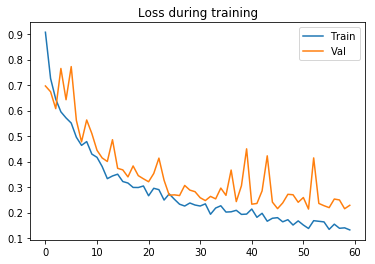

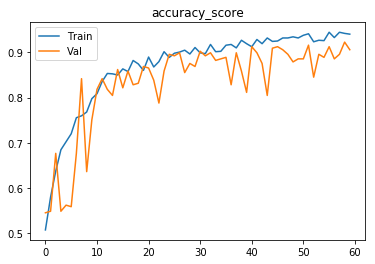

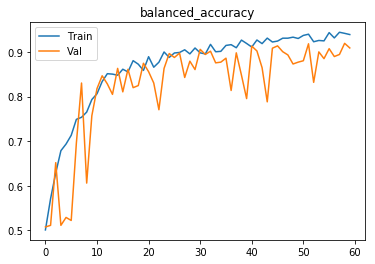

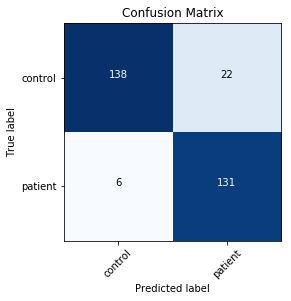

Starting trial 1
[0,   100] loss: 1.08480
[0,   200] loss: 0.78525
Time elapsed: 0h:3m:2s
train accuracy_score: 53.88 %
train balanced_accuracy: 53.13 %
val accuracy_score: 53.87 %
val balanced_accuracy: 50.00 %
Val loss: 0.911838
[1,   100] loss: 0.75183
[1,   200] loss: 0.76418
Time elapsed: 0h:7m:3s
train accuracy_score: 52.45 %
train balanced_accuracy: 51.37 %
val accuracy_score: 47.14 %
val balanced_accuracy: 50.94 %
Val loss: 0.690702
[2,   100] loss: 0.68104
[2,   200] loss: 0.66579
Time elapsed: 0h:11m:6s
train accuracy_score: 59.44 %
train balanced_accuracy: 58.14 %
val accuracy_score: 52.53 %
val balanced_accuracy: 55.68 %
Val loss: 0.675407
[3,   100] loss: 0.64671
[3,   200] loss: 0.62946
Time elapsed: 0h:15m:7s
train accuracy_score: 62.48 %
train balanced_accuracy: 61.46 %
val accuracy_score: 58.59 %
val balanced_accuracy: 55.11 %
Val loss: 0.623443
[4,   100] loss: 0.60148
[4,   200] loss: 0.63494
Time elapsed: 0h:19m:6s
train accuracy_score: 65.51 %
train balanced_accura

[38,   100] loss: 0.17500
[38,   200] loss: 0.20420
Time elapsed: 2h:34m:7s
train accuracy_score: 91.65 %
train balanced_accuracy: 91.61 %
val accuracy_score: 89.23 %
val balanced_accuracy: 89.63 %
Val loss: 0.247862
[39,   100] loss: 0.19950
[39,   200] loss: 0.19883
Time elapsed: 2h:38m:3s
train accuracy_score: 92.50 %
train balanced_accuracy: 92.43 %
val accuracy_score: 89.23 %
val balanced_accuracy: 89.37 %
Val loss: 0.246273
[40,   100] loss: 0.19655
[40,   200] loss: 0.18425
Time elapsed: 2h:41m:57s
train accuracy_score: 91.48 %
train balanced_accuracy: 91.36 %
val accuracy_score: 85.52 %
val balanced_accuracy: 84.78 %
Val loss: 0.323817
[41,   100] loss: 0.16879
[41,   200] loss: 0.16235
Time elapsed: 2h:45m:53s
train accuracy_score: 92.92 %
train balanced_accuracy: 92.78 %
val accuracy_score: 89.90 %
val balanced_accuracy: 90.15 %
Val loss: 0.251277
[42,   100] loss: 0.20186
[42,   200] loss: 0.17450
Time elapsed: 2h:49m:51s
train accuracy_score: 91.91 %
train balanced_accuracy

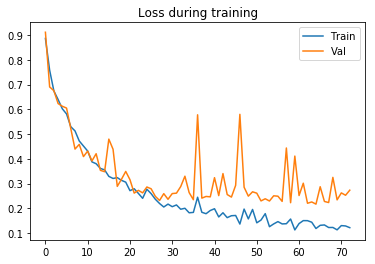

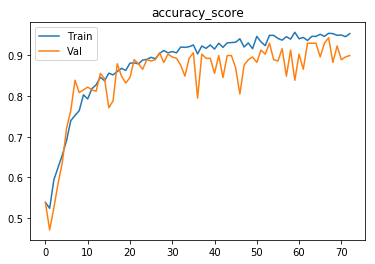

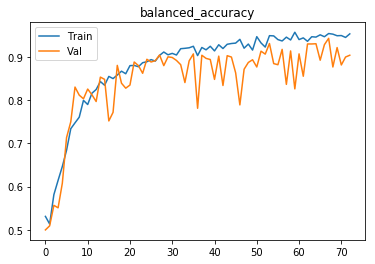

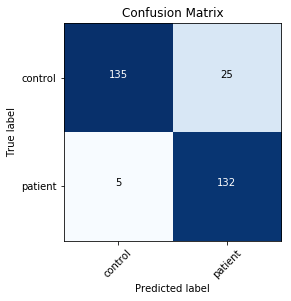

Starting trial 2
[0,   100] loss: 0.98770
[0,   200] loss: 0.77750
Time elapsed: 0h:3m:0s
train accuracy_score: 54.47 %
train balanced_accuracy: 53.60 %
val accuracy_score: 46.80 %
val balanced_accuracy: 50.36 %
Val loss: 0.677867
[1,   100] loss: 0.71025
[1,   200] loss: 0.70408
Time elapsed: 0h:6m:56s
train accuracy_score: 58.68 %
train balanced_accuracy: 57.87 %
val accuracy_score: 59.60 %
val balanced_accuracy: 56.20 %
Val loss: 0.620388
[2,   100] loss: 0.67069
[2,   200] loss: 0.63433
Time elapsed: 0h:10m:51s
train accuracy_score: 62.31 %
train balanced_accuracy: 61.47 %
val accuracy_score: 56.90 %
val balanced_accuracy: 53.28 %
Val loss: 0.645218
[3,   100] loss: 0.59636
[3,   200] loss: 0.57682
Time elapsed: 0h:14m:50s
train accuracy_score: 69.22 %
train balanced_accuracy: 68.35 %
val accuracy_score: 66.67 %
val balanced_accuracy: 63.92 %
Val loss: 0.569964
[4,   100] loss: 0.53833
[4,   200] loss: 0.58482
Time elapsed: 0h:18m:46s
train accuracy_score: 69.90 %
train balanced_ac

val accuracy_score: 91.58 %
val balanced_accuracy: 91.30 %
Val loss: 0.222424
[38,   100] loss: 0.16468
[38,   200] loss: 0.18476
Time elapsed: 2h:33m:6s
train accuracy_score: 92.33 %
train balanced_accuracy: 92.21 %
val accuracy_score: 88.89 %
val balanced_accuracy: 88.69 %
Val loss: 0.250612
[39,   100] loss: 0.19336
[39,   200] loss: 0.15332
Time elapsed: 2h:37m:3s
train accuracy_score: 92.16 %
train balanced_accuracy: 92.14 %
val accuracy_score: 88.55 %
val balanced_accuracy: 88.48 %
Val loss: 0.244755
[40,   100] loss: 0.17966
[40,   200] loss: 0.20489
Time elapsed: 2h:40m:59s
train accuracy_score: 91.65 %
train balanced_accuracy: 91.51 %
val accuracy_score: 89.56 %
val balanced_accuracy: 89.89 %
Val loss: 0.252918
[41,   100] loss: 0.17544
[41,   200] loss: 0.19332
Time elapsed: 2h:44m:55s
train accuracy_score: 92.16 %
train balanced_accuracy: 92.12 %
val accuracy_score: 89.23 %
val balanced_accuracy: 88.85 %
Val loss: 0.235497
[42,   100] loss: 0.16921
[42,   200] loss: 0.16197


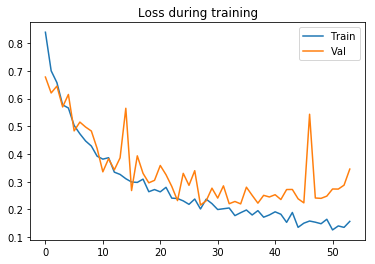

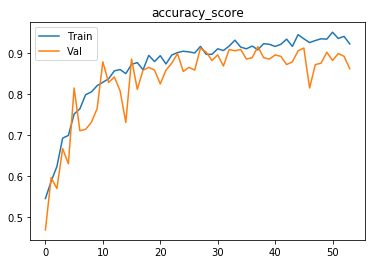

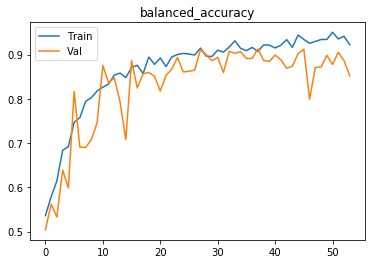

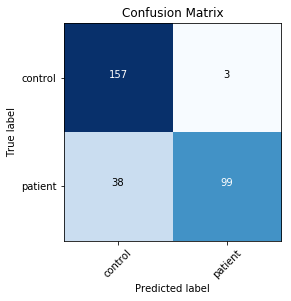

Starting trial 3
[0,   100] loss: 0.96515
[0,   200] loss: 0.80698
Time elapsed: 0h:3m:0s
train accuracy_score: 52.70 %
train balanced_accuracy: 51.90 %
val accuracy_score: 54.88 %
val balanced_accuracy: 51.09 %
Val loss: 0.680101
[1,   100] loss: 0.71452
[1,   200] loss: 0.74891
Time elapsed: 0h:6m:56s
train accuracy_score: 53.29 %
train balanced_accuracy: 52.30 %
val accuracy_score: 56.57 %
val balanced_accuracy: 59.53 %
Val loss: 0.673912
[2,   100] loss: 0.65323
[2,   200] loss: 0.65601
Time elapsed: 0h:10m:53s
train accuracy_score: 60.29 %
train balanced_accuracy: 59.15 %
val accuracy_score: 64.98 %
val balanced_accuracy: 62.04 %
Val loss: 0.622869
[3,   100] loss: 0.62989
[3,   200] loss: 0.59352
Time elapsed: 0h:14m:49s
train accuracy_score: 66.36 %
train balanced_accuracy: 65.37 %
val accuracy_score: 52.86 %
val balanced_accuracy: 56.25 %
Val loss: 0.643656
[4,   100] loss: 0.61311
[4,   200] loss: 0.54301
Time elapsed: 0h:18m:46s
train accuracy_score: 68.89 %
train balanced_ac

[38,   100] loss: 0.18852
[38,   200] loss: 0.17171
Time elapsed: 2h:32m:18s
train accuracy_score: 92.50 %
train balanced_accuracy: 92.41 %
val accuracy_score: 90.24 %
val balanced_accuracy: 90.83 %
Val loss: 0.252379
[39,   100] loss: 0.20937
[39,   200] loss: 0.20575
Time elapsed: 2h:36m:14s
train accuracy_score: 90.30 %
train balanced_accuracy: 90.33 %
val accuracy_score: 78.79 %
val balanced_accuracy: 77.01 %
Val loss: 0.428126
[40,   100] loss: 0.17458
[40,   200] loss: 0.22757
Time elapsed: 2h:40m:10s
train accuracy_score: 91.57 %
train balanced_accuracy: 91.49 %
val accuracy_score: 88.89 %
val balanced_accuracy: 88.85 %
Val loss: 0.267125
[41,   100] loss: 0.19057
[41,   200] loss: 0.25105
Time elapsed: 2h:44m:6s
train accuracy_score: 90.89 %
train balanced_accuracy: 90.87 %
val accuracy_score: 88.55 %
val balanced_accuracy: 89.22 %
Val loss: 0.273082
[42,   100] loss: 0.16993
[42,   200] loss: 0.21675
Time elapsed: 2h:48m:1s
train accuracy_score: 92.66 %
train balanced_accuracy

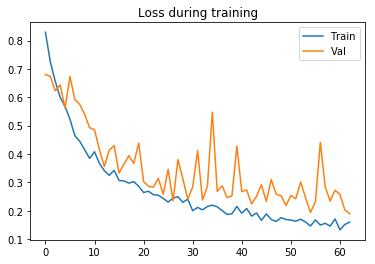

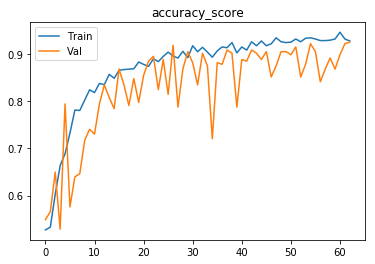

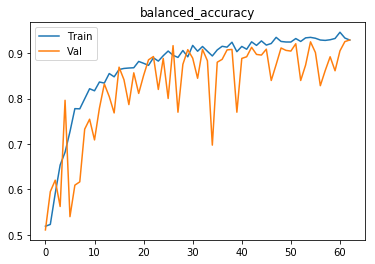

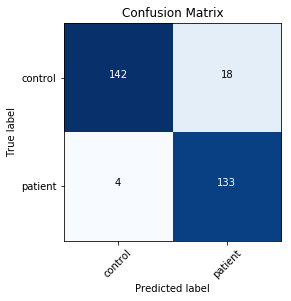

Starting trial 4
[0,   100] loss: 0.98425
[0,   200] loss: 0.96128
Time elapsed: 0h:3m:0s
train accuracy_score: 50.67 %
train balanced_accuracy: 49.91 %
val accuracy_score: 46.13 %
val balanced_accuracy: 50.00 %
Val loss: 0.788382
[1,   100] loss: 0.72350
[1,   200] loss: 0.72812
Time elapsed: 0h:6m:55s
train accuracy_score: 57.17 %
train balanced_accuracy: 56.49 %
val accuracy_score: 47.47 %
val balanced_accuracy: 51.25 %
Val loss: 0.679923
[2,   100] loss: 0.68148
[2,   200] loss: 0.66000
Time elapsed: 0h:10m:50s
train accuracy_score: 62.98 %
train balanced_accuracy: 62.05 %
val accuracy_score: 55.22 %
val balanced_accuracy: 51.46 %
Val loss: 0.767955
[3,   100] loss: 0.63641
[3,   200] loss: 0.57819
Time elapsed: 0h:14m:46s
train accuracy_score: 66.86 %
train balanced_accuracy: 65.97 %
val accuracy_score: 61.62 %
val balanced_accuracy: 63.85 %
Val loss: 0.631024
[4,   100] loss: 0.59138
[4,   200] loss: 0.56958
Time elapsed: 0h:18m:39s
train accuracy_score: 71.42 %
train balanced_ac

[38,   100] loss: 0.16416
[38,   200] loss: 0.19808
Time elapsed: 2h:32m:5s
train accuracy_score: 91.74 %
train balanced_accuracy: 91.62 %
val accuracy_score: 88.22 %
val balanced_accuracy: 87.49 %
Val loss: 0.274100
[39,   100] loss: 0.19129
[39,   200] loss: 0.17962
Time elapsed: 2h:36m:0s
train accuracy_score: 91.99 %
train balanced_accuracy: 91.95 %
val accuracy_score: 92.59 %
val balanced_accuracy: 92.76 %
Val loss: 0.210283
[40,   100] loss: 0.13278
[40,   200] loss: 0.18805
Time elapsed: 2h:39m:56s
train accuracy_score: 93.34 %
train balanced_accuracy: 93.25 %
val accuracy_score: 82.15 %
val balanced_accuracy: 81.02 %
Val loss: 0.388858
[41,   100] loss: 0.21303
[41,   200] loss: 0.15025
Time elapsed: 2h:43m:54s
train accuracy_score: 92.92 %
train balanced_accuracy: 92.90 %
val accuracy_score: 82.83 %
val balanced_accuracy: 81.75 %
Val loss: 0.383291
[42,   100] loss: 0.18996
[42,   200] loss: 0.14302
Time elapsed: 2h:47m:55s
train accuracy_score: 91.65 %
train balanced_accuracy

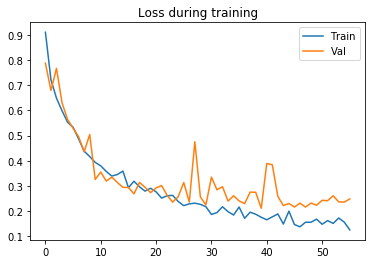

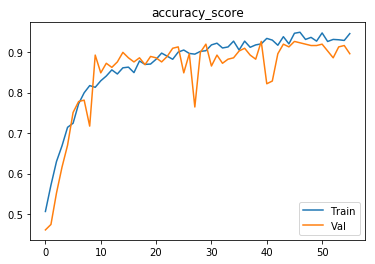

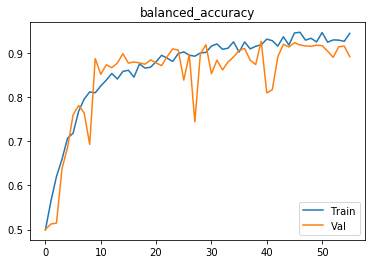

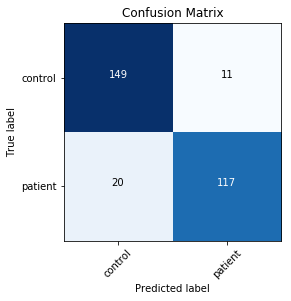

Starting trial 5
[0,   100] loss: 1.22166
[0,   200] loss: 0.83321
Time elapsed: 0h:3m:10s
train accuracy_score: 53.54 %
train balanced_accuracy: 52.82 %
val accuracy_score: 53.87 %
val balanced_accuracy: 50.00 %
Val loss: 1.039360
[1,   100] loss: 0.80854
[1,   200] loss: 0.72778
Time elapsed: 0h:8m:34s
train accuracy_score: 54.22 %
train balanced_accuracy: 53.52 %
val accuracy_score: 54.21 %
val balanced_accuracy: 50.36 %
Val loss: 0.783164
[2,   100] loss: 0.71243
[2,   200] loss: 0.67040
Time elapsed: 0h:13m:43s
train accuracy_score: 57.76 %
train balanced_accuracy: 56.69 %
val accuracy_score: 59.60 %
val balanced_accuracy: 56.20 %
Val loss: 0.618188
[3,   100] loss: 0.65657
[3,   200] loss: 0.66235
Time elapsed: 0h:18m:4s
train accuracy_score: 62.98 %
train balanced_accuracy: 61.90 %
val accuracy_score: 54.88 %
val balanced_accuracy: 51.09 %
Val loss: 0.659193
[4,   100] loss: 0.57946
[4,   200] loss: 0.55222
Time elapsed: 0h:22m:16s
train accuracy_score: 69.22 %
train balanced_ac

[38,   100] loss: 0.19349
[38,   200] loss: 0.19869
Time elapsed: 2h:52m:31s
train accuracy_score: 90.30 %
train balanced_accuracy: 90.23 %
val accuracy_score: 90.24 %
val balanced_accuracy: 90.31 %
Val loss: 0.232324
[39,   100] loss: 0.25112
[39,   200] loss: 0.20032
Time elapsed: 2h:56m:45s
train accuracy_score: 90.98 %
train balanced_accuracy: 91.02 %
val accuracy_score: 88.89 %
val balanced_accuracy: 88.53 %
Val loss: 0.254640
[40,   100] loss: 0.24201
[40,   200] loss: 0.21738
Time elapsed: 3h:1m:8s
train accuracy_score: 89.46 %
train balanced_accuracy: 89.27 %
val accuracy_score: 89.90 %
val balanced_accuracy: 90.42 %
Val loss: 0.252026
[41,   100] loss: 0.19463
[41,   200] loss: 0.19612
Time elapsed: 3h:5m:8s
train accuracy_score: 90.98 %
train balanced_accuracy: 90.92 %
val accuracy_score: 89.56 %
val balanced_accuracy: 89.63 %
Val loss: 0.223283
[42,   100] loss: 0.23341
[42,   200] loss: 0.20190
Time elapsed: 3h:9m:23s
train accuracy_score: 90.13 %
train balanced_accuracy: 9

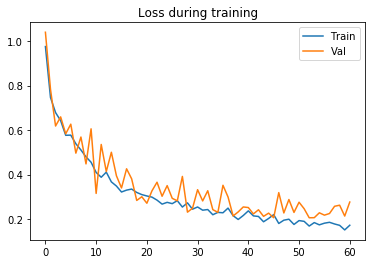

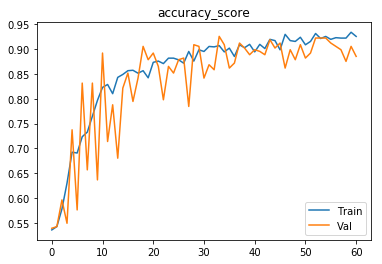

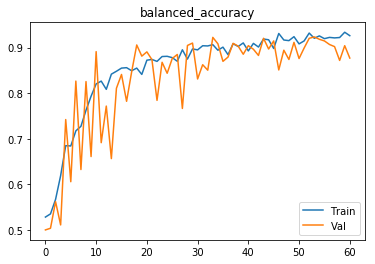

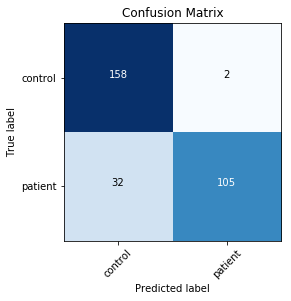

Starting trial 6
[0,   100] loss: 1.19938
[0,   200] loss: 1.15673
Time elapsed: 0h:2m:59s
train accuracy_score: 53.04 %
train balanced_accuracy: 52.46 %
val accuracy_score: 53.87 %
val balanced_accuracy: 50.00 %
Val loss: 0.782336
[1,   100] loss: 0.77640
[1,   200] loss: 0.70580
Time elapsed: 0h:7m:1s
train accuracy_score: 57.08 %
train balanced_accuracy: 55.93 %
val accuracy_score: 57.58 %
val balanced_accuracy: 54.43 %
Val loss: 0.642288
[2,   100] loss: 0.68705
[2,   200] loss: 0.62745
Time elapsed: 0h:11m:5s
train accuracy_score: 62.31 %
train balanced_accuracy: 61.42 %
val accuracy_score: 61.95 %
val balanced_accuracy: 58.81 %
Val loss: 0.594323
[3,   100] loss: 0.65242
[3,   200] loss: 0.58957
Time elapsed: 0h:15m:32s
train accuracy_score: 67.28 %
train balanced_accuracy: 66.60 %
val accuracy_score: 72.39 %
val balanced_accuracy: 70.13 %
Val loss: 0.563465
[4,   100] loss: 0.62899
[4,   200] loss: 0.58394
Time elapsed: 0h:19m:57s
train accuracy_score: 66.78 %
train balanced_acc

[38,   100] loss: 0.19066
[38,   200] loss: 0.17884
Time elapsed: 2h:38m:32s
train accuracy_score: 91.06 %
train balanced_accuracy: 91.08 %
val accuracy_score: 84.51 %
val balanced_accuracy: 83.32 %
Val loss: 0.334604
[39,   100] loss: 0.18996
[39,   200] loss: 0.22296
Time elapsed: 2h:42m:48s
train accuracy_score: 92.07 %
train balanced_accuracy: 92.10 %
val accuracy_score: 90.57 %
val balanced_accuracy: 90.78 %
Val loss: 0.238442
[40,   100] loss: 0.16631
[40,   200] loss: 0.18224
Time elapsed: 2h:46m:42s
train accuracy_score: 91.65 %
train balanced_accuracy: 91.60 %
val accuracy_score: 86.53 %
val balanced_accuracy: 85.93 %
Val loss: 0.285893
[41,   100] loss: 0.20955
[41,   200] loss: 0.16085
Time elapsed: 2h:50m:41s
train accuracy_score: 91.82 %
train balanced_accuracy: 91.73 %
val accuracy_score: 89.90 %
val balanced_accuracy: 90.26 %
Val loss: 0.248032
[42,   100] loss: 0.18421
[42,   200] loss: 0.14216
Time elapsed: 2h:54m:34s
train accuracy_score: 91.99 %
train balanced_accura

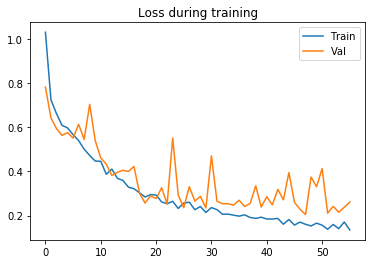

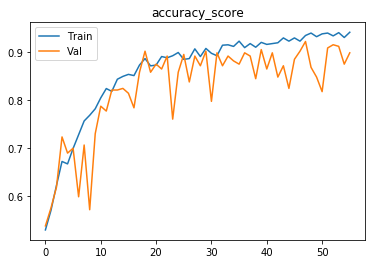

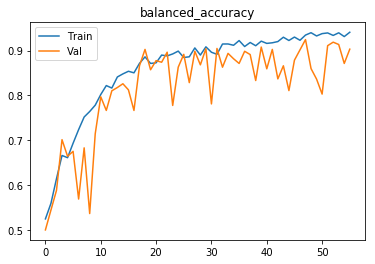

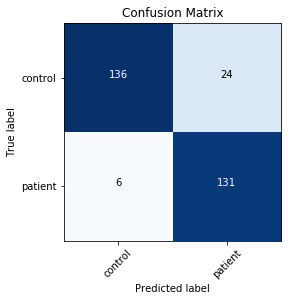

Starting trial 7
[0,   100] loss: 1.09500
[0,   200] loss: 0.97579
Time elapsed: 0h:3m:0s
train accuracy_score: 52.02 %
train balanced_accuracy: 51.45 %
val accuracy_score: 53.87 %
val balanced_accuracy: 50.00 %
Val loss: 0.801137
[1,   100] loss: 0.76696
[1,   200] loss: 0.74121
Time elapsed: 0h:6m:56s
train accuracy_score: 56.24 %
train balanced_accuracy: 55.44 %
val accuracy_score: 58.25 %
val balanced_accuracy: 60.67 %
Val loss: 0.671711
[2,   100] loss: 0.67687
[2,   200] loss: 0.64474
Time elapsed: 0h:10m:52s
train accuracy_score: 62.98 %
train balanced_accuracy: 61.92 %
val accuracy_score: 75.42 %
val balanced_accuracy: 74.30 %
Val loss: 0.605457
[3,   100] loss: 0.61851
[3,   200] loss: 0.55578
Time elapsed: 0h:14m:46s
train accuracy_score: 69.22 %
train balanced_accuracy: 68.44 %
val accuracy_score: 71.04 %
val balanced_accuracy: 68.98 %
Val loss: 0.554832
[4,   100] loss: 0.54868
[4,   200] loss: 0.57021
Time elapsed: 0h:18m:40s
train accuracy_score: 72.18 %
train balanced_ac

[38,   100] loss: 0.18134
[38,   200] loss: 0.16383
Time elapsed: 2h:33m:28s
train accuracy_score: 91.65 %
train balanced_accuracy: 91.61 %
val accuracy_score: 90.91 %
val balanced_accuracy: 90.93 %
Val loss: 0.221566
[39,   100] loss: 0.19845
[39,   200] loss: 0.17712
Time elapsed: 2h:37m:20s
train accuracy_score: 92.33 %
train balanced_accuracy: 92.28 %
val accuracy_score: 82.49 %
val balanced_accuracy: 81.39 %
Val loss: 0.379972
[40,   100] loss: 0.16815
[40,   200] loss: 0.18703
Time elapsed: 2h:41m:20s
train accuracy_score: 92.66 %
train balanced_accuracy: 92.62 %
val accuracy_score: 87.88 %
val balanced_accuracy: 87.75 %
Val loss: 0.209542
[41,   100] loss: 0.16683
[41,   200] loss: 0.18017
Time elapsed: 2h:45m:22s
train accuracy_score: 93.42 %
train balanced_accuracy: 93.43 %
val accuracy_score: 89.56 %
val balanced_accuracy: 89.58 %
Val loss: 0.223261
[42,   100] loss: 0.19625
[42,   200] loss: 0.16532
Time elapsed: 2h:49m:16s
train accuracy_score: 92.41 %
train balanced_accura

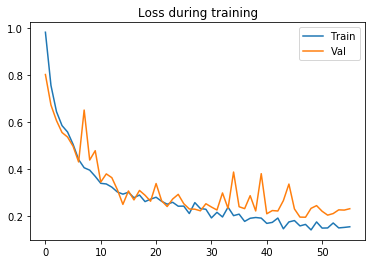

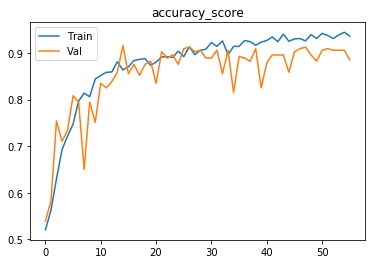

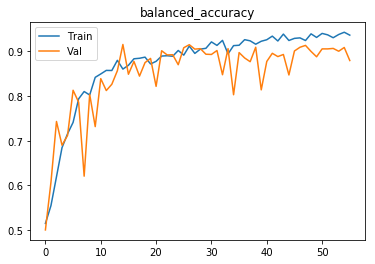

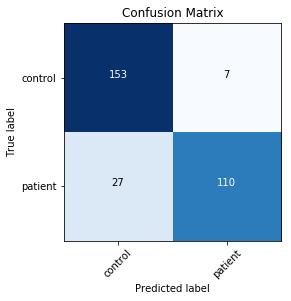

Starting trial 8
[0,   100] loss: 0.97194
[0,   200] loss: 0.86468
Time elapsed: 0h:2m:57s
train accuracy_score: 52.02 %
train balanced_accuracy: 51.15 %
val accuracy_score: 55.56 %
val balanced_accuracy: 51.82 %
Val loss: 0.657193
[1,   100] loss: 0.69289
[1,   200] loss: 0.75496
Time elapsed: 0h:6m:43s
train accuracy_score: 55.82 %
train balanced_accuracy: 54.86 %
val accuracy_score: 54.21 %
val balanced_accuracy: 50.36 %
Val loss: 0.778952
[2,   100] loss: 0.70954
[2,   200] loss: 0.66892
Time elapsed: 0h:10m:30s
train accuracy_score: 59.95 %
train balanced_accuracy: 58.80 %
val accuracy_score: 54.88 %
val balanced_accuracy: 51.09 %
Val loss: 0.665232
[3,   100] loss: 0.59666
[3,   200] loss: 0.62393
Time elapsed: 0h:14m:17s
train accuracy_score: 65.94 %
train balanced_accuracy: 65.24 %
val accuracy_score: 54.21 %
val balanced_accuracy: 57.34 %
Val loss: 0.683461
[4,   100] loss: 0.58121
[4,   200] loss: 0.57447
Time elapsed: 0h:18m:3s
train accuracy_score: 70.07 %
train balanced_ac

[38,   100] loss: 0.23223
[38,   200] loss: 0.19338
Time elapsed: 2h:26m:12s
train accuracy_score: 91.57 %
train balanced_accuracy: 91.47 %
val accuracy_score: 86.87 %
val balanced_accuracy: 87.55 %
Val loss: 0.275636
[39,   100] loss: 0.19657
[39,   200] loss: 0.24035
Time elapsed: 2h:29m:59s
train accuracy_score: 90.56 %
train balanced_accuracy: 90.43 %
val accuracy_score: 86.20 %
val balanced_accuracy: 86.61 %
Val loss: 0.305285
[40,   100] loss: 0.18786
[40,   200] loss: 0.16232
Time elapsed: 2h:33m:45s
train accuracy_score: 91.82 %
train balanced_accuracy: 91.77 %
val accuracy_score: 87.21 %
val balanced_accuracy: 87.71 %
Val loss: 0.301588
[41,   100] loss: 0.20827
[41,   200] loss: 0.19777
Time elapsed: 2h:37m:33s
train accuracy_score: 91.74 %
train balanced_accuracy: 91.66 %
val accuracy_score: 86.53 %
val balanced_accuracy: 86.98 %
Val loss: 0.278405
[42,   100] loss: 0.17736
[42,   200] loss: 0.22383
Time elapsed: 2h:41m:19s
train accuracy_score: 91.57 %
train balanced_accura

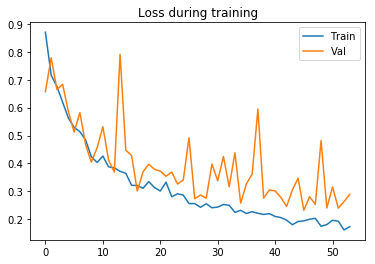

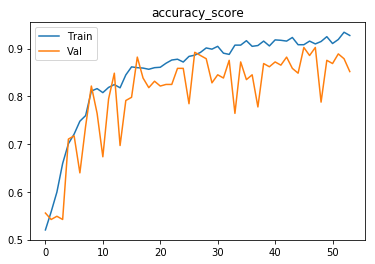

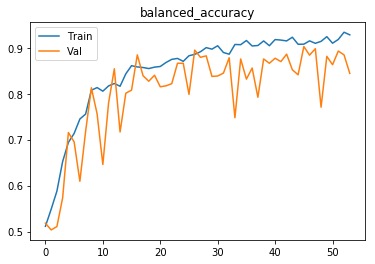

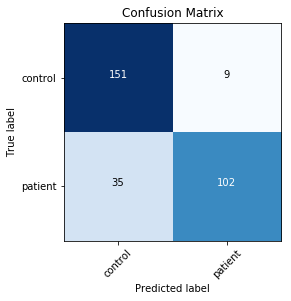

Starting trial 9
[0,   100] loss: 0.97690
[0,   200] loss: 0.76370
Time elapsed: 0h:2m:57s
train accuracy_score: 52.95 %
train balanced_accuracy: 52.38 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.73 %
Val loss: 0.682777
[1,   100] loss: 0.73885
[1,   200] loss: 0.69297
Time elapsed: 0h:6m:44s
train accuracy_score: 58.60 %
train balanced_accuracy: 57.59 %
val accuracy_score: 50.17 %
val balanced_accuracy: 53.70 %
Val loss: 0.670244
[2,   100] loss: 0.65400
[2,   200] loss: 0.67610
Time elapsed: 0h:10m:31s
train accuracy_score: 61.05 %
train balanced_accuracy: 60.07 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.73 %
Val loss: 0.760815
[3,   100] loss: 0.63209
[3,   200] loss: 0.68243
Time elapsed: 0h:14m:20s
train accuracy_score: 62.98 %
train balanced_accuracy: 62.12 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.73 %
Val loss: 0.725457
[4,   100] loss: 0.60289
[4,   200] loss: 0.57790
Time elapsed: 0h:18m:6s
train accuracy_score: 68.72 %
train balanced_ac

[38,   100] loss: 0.14135
[38,   200] loss: 0.15865
Time elapsed: 2h:26m:5s
train accuracy_score: 93.09 %
train balanced_accuracy: 93.05 %
val accuracy_score: 91.25 %
val balanced_accuracy: 91.46 %
Val loss: 0.228765
[39,   100] loss: 0.15761
[39,   200] loss: 0.18854
Time elapsed: 2h:29m:52s
train accuracy_score: 92.07 %
train balanced_accuracy: 92.05 %
val accuracy_score: 90.24 %
val balanced_accuracy: 90.78 %
Val loss: 0.254037
[40,   100] loss: 0.18498
[40,   200] loss: 0.15051
Time elapsed: 2h:33m:39s
train accuracy_score: 92.50 %
train balanced_accuracy: 92.46 %
val accuracy_score: 89.90 %
val balanced_accuracy: 89.26 %
Val loss: 0.255858
[41,   100] loss: 0.20284
[41,   200] loss: 0.16958
Time elapsed: 2h:37m:24s
train accuracy_score: 92.41 %
train balanced_accuracy: 92.35 %
val accuracy_score: 87.88 %
val balanced_accuracy: 87.65 %
Val loss: 0.281418
[42,   100] loss: 0.14622
[42,   200] loss: 0.19983
Time elapsed: 2h:41m:11s
train accuracy_score: 92.16 %
train balanced_accurac

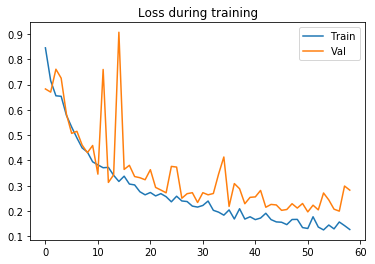

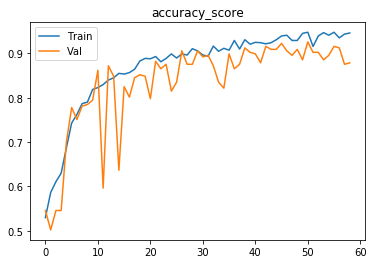

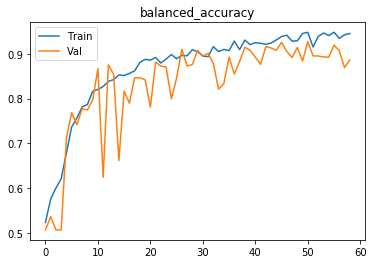

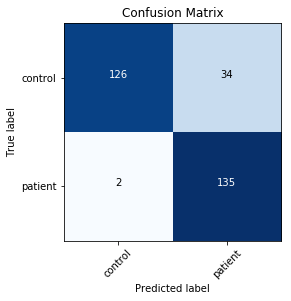

################################
################################
All accuracies: [0.909352189781022, 0.9036268248175183, 0.8519388686131386, 0.9291514598540146, 0.892632299270073, 0.876961678832117, 0.9031021897810219, 0.8795848540145984, 0.8441377737226277, 0.8864507299270072]
0.8876938868613138
0.024620140404635057


In [29]:
fold_metric, models = run(net=net, data=train_df,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=b
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [30]:
5/0

ZeroDivisionError: division by zero

In [ ]:
output_dir = "/analysis/ritter/projects/Methods/Eitel_local_filter/models"

In [ ]:
def save_model(model, full_path):
    print("Writing model to disk...")
    model = model.cpu()
    torch.save(model.state_dict(), full_path)

In [ ]:
save_models = False

In [ ]:
if save_models:
    for i, model in enumerate(models):
        model_dir = os.path.join(output_dir, "adni_baseline_499k_augmentation_copy1_84_acc_trial_{}.h5".format(i))
        save_model(model, model_dir)

# Start inference

In [31]:
if zero_one_normalize:
    ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
else:
    ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([ToTensor()]), mask=mask)
            
test_loader = DataLoader(
            ukb_data_test, batch_size=1, num_workers=1, shuffle=False
)

In [32]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model in enumerate(models):
    print("Fold {}".format(fold))

    all_preds = []
    all_labels = []
    
    net = model.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]

            img = img.to(torch.device("cuda:" + str(gpu)))

            output = net.forward(img)
            pred = torch.sigmoid(output) >= 0.5
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    #print(all_preds)
    #print(all_labels)
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    print(balanced_acc)
    '''trainer = Trainer(
                net,
                criterion,
                optimizer,
                scheduler=None,
                metrics=metrics,
                callbacks=None,
                device=gpu,
                prediction_type="binary"
            )
    computed_metrics = trainer.evaluate_model(test_loader, metrics=[balanced_accuracy])'''
    net.train()
    metrics.append(balanced_acc)
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df[0])*100))


Fold 0
0.9162880773487099
Fold 1
0.895669520647679
Fold 2
0.8649018579998835
Fold 3
0.9157929990098433
Fold 4
0.9092550527112819
Fold 5
0.885170947638185
Fold 6
0.884865163958297
Fold 7
0.9005329372706623
Fold 8
0.883336245558856
Fold 9
0.8959170598171122
######## Final results ########
          0
0  0.916288
1  0.895670
2  0.864902
3  0.915793
4  0.909255
5  0.885171
6  0.884865
7  0.900533
8  0.883336
9  0.895917
Balanced accuracy mean 89.52 %
